In [1]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from stimulus_presentation import visual_p300_stripes
from utils import utils
from collections import OrderedDict

# P300

This notebook will run a P300 experiment to analyze event-related potentials related to the detection of 'oddball' visual stimuli.

# Step 1: Connect to an EEG Device
*Note: if using Windows 10 and BlueMuse, skip this section and connect using the BlueMuse GUI*

Make sure your device is turned on and run the following code. It should detect and connect to the device and begin 'Streaming...'

If the device is not found or the connection times out, try running this code again

In [2]:
# Search for available Muse devices
muses = list_muses()

Starting BlueMuse, see BlueMuse window for interactive list of devices.


In [ ]:
# Start a background process that will stream data from the first available Muse
stream_process = Process(target=stream, args=(muses[0]['address'],))
stream_process.start()

# Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
Put the Muse on and run the following code to view the raw EEG data stream.

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

In [10]:
%matplotlib tk
view()

Looking for an EEG stream...
Start acquiring data.

                toggle filter : d
                toogle full screen : f
                zoom out : /
                zoom in : *
                increase time scale : -
                decrease time scale : +
               


# Step 3: Run the Experiment
Modify the variables in the following code chunk to define how long you want to run the experiment and the name of the subject and session you are running. Then, seat the subject in front of the computer and have them quietly view the screen until the experiment is completed.

This is a simple oddball paradigm involving stimuli with two orientations of gratings.

Stimulus were presented for 200ms at an interval of 600ms with a random jitter of +- 100ms.

In [2]:
# Define these parameters 
duration = 120
subject = 12
session = 1

In [3]:
recording_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", "P300", "subject" + str(subject), "session" + str(session), ("recording_%s.csv" %
                                              strftime("%Y-%m-%d-%H.%M.%S", gmtime())) + ".csv")

stimulus = Process(target=visual_p300_stripes.present, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

# Step 4: Clean the Data

## Load data into MNE objects

In [5]:
raw = utils.load_data('visual/P300', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30552
    Range : 0 ... 30551 =      0.000 ...   119.340 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


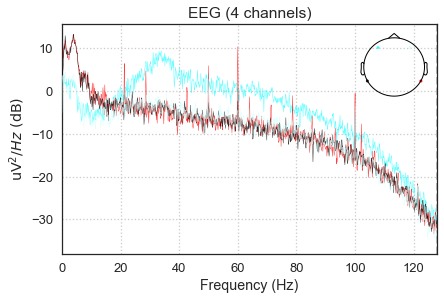

In [6]:
%matplotlib inline
raw.plot_psd();

## Filtering
Filter the data between 1 and 30hz

In [7]:
raw.filter(1,30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 5 x 30552 (119.3 sec), ~1.2 MB, data loaded>

## Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceed 75 uV. This mainly rejects blinks.

In [8]:
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print 'sample drop %: ', (1 - float(len(epochs.events))/float(len(events))) * 100
epochs

144 events found
Event IDs: [1 2]
sample drop %:  4.86111111111


<Epochs  |   137 events (all good), -0.101562 - 0.800781 sec, baseline off, ~1012 kB, data loaded,
 'Non-Target': 113
 'Target': 24>

# Step 5: Analyze the Data

Now we can analyze our results by averaing the epochs and looking for differences between epochs when faces or houses were presented


## Epoch average

Now we can plot the average ERP for both conditions:

c:\users\dailyuser\miniconda2\envs\brainwaves\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


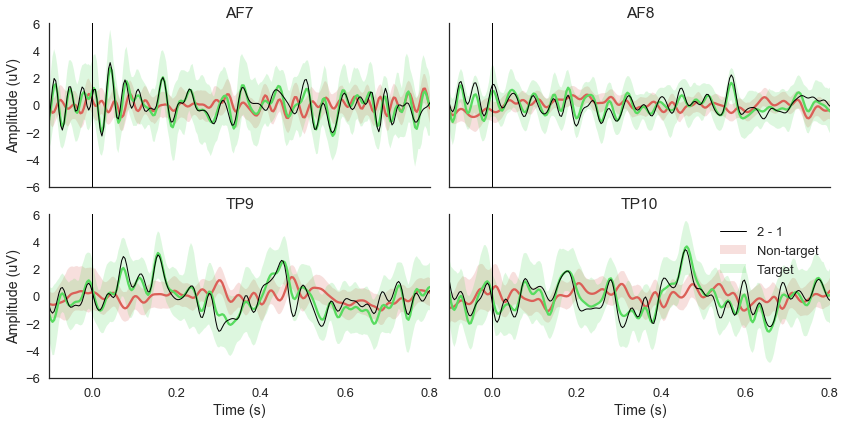

In [9]:
%matplotlib inline
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

 ## What do you see? Describe the shape of the waveform